In [73]:
import numpy as np
import pandas as pd
import os
import io
import zipfile
import sys
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
plt.rcParams['font.family'] = 'DejaVu Serif'

**UPLOAD THE DATA SUBSET**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving raw-data-subset.zip to raw-data-subset (2).zip


**EXTRACT THE FILES FROM THE CSVs**

In [ ]:
file_path = '/content/raw-data.zip'


with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

main_zip_path = '/content/raw-data'
main_folder_files = os.listdir(main_zip_path)

for file in main_folder_files:
    if file.endswith('.zip'):
        inner_zip_file = os.path.join(main_zip_path, file)

        inner_extracted_folder = os.path.join(main_zip_path, file.replace('.zip', ''))
        os.makedirs(inner_extracted_folder, exist_ok=True)

        with zipfile.ZipFile(inner_zip_file, 'r') as inner_zip_ref:
            inner_zip_ref.extractall(inner_extracted_folder)

        print(f"Extracted: {inner_zip_file} -> {inner_extracted_folder}")

Extracted: /content/raw-data/order_products__train.csv.zip -> /content/raw-data/order_products__train.csv
Extracted: /content/raw-data/departments.csv.zip -> /content/raw-data/departments.csv
Extracted: /content/raw-data/products.csv.zip -> /content/raw-data/products.csv
Extracted: /content/raw-data/aisles.csv.zip -> /content/raw-data/aisles.csv
Extracted: /content/raw-data/orders.csv.zip -> /content/raw-data/orders.csv


**READ THE CSVs AND MAKE THE DATAFRAMES**

In [7]:
aisle_fp = 'aisles.csv'
department_fp = 'departments.csv'
prior_orders_fp = 'order_products__prior.csv'
orders_fp = 'orders.csv'
product_fp = 'products.csv'

# Read CSVs into DataFrames
aisles = pd.read_csv(aisle_fp)
departments = pd.read_csv(department_fp)
orders_prior = pd.read_csv(prior_orders_fp)
orders = pd.read_csv(orders_fp)
products = pd.read_csv(product_fp)

In [8]:
print(aisles.head())
print(departments.head())
print(orders_prior.head())
print(orders.head())
print(products.head())

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior        

**FIX NULL VALUES**

In [9]:
# We need to figure out what dataframes have null values
print("Products:")
print(products.isna().sum())
print()

print("Aisles:")
print(aisles.isna().sum())
print()

print("Departments:")
print(departments.isna().sum())
print()

print("Orders:")
print(orders.isna().sum())
print()

print("Prior Orders:")
print(orders_prior.isna().sum())
print()

Products:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Aisles:
aisle_id    0
aisle       0
dtype: int64

Departments:
department_id    0
department       0
dtype: int64

Orders:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Prior Orders:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64



In [5]:
# Orders has null values in 'days_since_prior_order'
orders['days_since_prior_order'] = orders['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x )

**CHANGE ANY DATA TYPES**

In [6]:
# Convert days_since_prior_order from float to int
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)

**SUMMARY OF DATA CLEANING CODE**

In [10]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x )
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)

**DATAFRAME OF ALL THE TABLES**

In [11]:
order_products = orders_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on ='order_id', how='left')
order_products = order_products.dropna()

In [12]:
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21


**FEATURE ENGINEERING**

Adding new columns:

* Total number of products per user
* Total number of orders per user
* How many unique aisles the user buys from

Purpose: to better analyze user purchasing behavior

What we are looking for:

* Wealth


In [13]:
orders_df1 = order_products.copy()

# Total number of products per user
user_product_counts = orders_df1.groupby('user_id')['product_id'].count().reset_index() # Group by user_id and calculate the total number of products purchased
user_product_counts.rename(columns={'product_id': 'total_products'}, inplace=True)  # rename column
orders_df1 = orders_df1.merge(user_product_counts, on='user_id', how='left') # Merge the total product counts back to the order_products DataFrame

# How many unique aisles the user buys from
user_unique_aisle_counts = orders_df1.groupby('user_id')['aisle_id'].nunique().reset_index()
user_unique_aisle_counts.rename(columns={'aisle_id': 'distinct_aisles'}, inplace=True)
orders_df1 = orders_df1.merge(user_unique_aisle_counts, on='user_id', how='left')

In [14]:
orders_df1

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_products,distinct_aisles
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8,90,27
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8,90,27
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8,90,27
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8,90,27
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8,90,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21,250,45
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21,250,45
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21,250,45
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21,250,45


**MERGING THE 2 FEATURE DERIVED ABOVE**

In [15]:
df_feat = pd.merge(user_product_counts, user_unique_aisle_counts, how='inner', on='user_id')
df_feat

,user_id,total_products,distinct_aisles
0,1,59,12
1,2,195,33
2,3,88,16
3,4,18,14
4,5,37,16
...,...,...,...
206204,206205,32,17
206205,206206,285,50
206206,206207,223,46
206207,206208,677,63


**FEATURE ENGINEERING STATS**

In [16]:
min_df = pd.DataFrame( df_feat.apply(lambda x: min(x), axis=0) ).T

max_df = pd.DataFrame( df_feat.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( df_feat.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( df_feat.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( df_feat.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( df_feat.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( df_feat.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( df_feat.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,user_id,1.0,206209.0,206208.0,103105.000000,103105.0,59527.410829,0.000000,-1.200000
1,total_products,3.0,3725.0,3722.0,157.289396,83.0,204.207738,3.179127,15.351197
2,distinct_aisles,1.0,102.0,101.0,27.783700,25.0,16.111491,0.713979,0.102604


**DISTRIBUTION OF FEATURES ADDED**

<Axes: title={'center': 'Distribution of distinct aisles bought from per user'}, xlabel='distinct_aisles', ylabel='Count'>

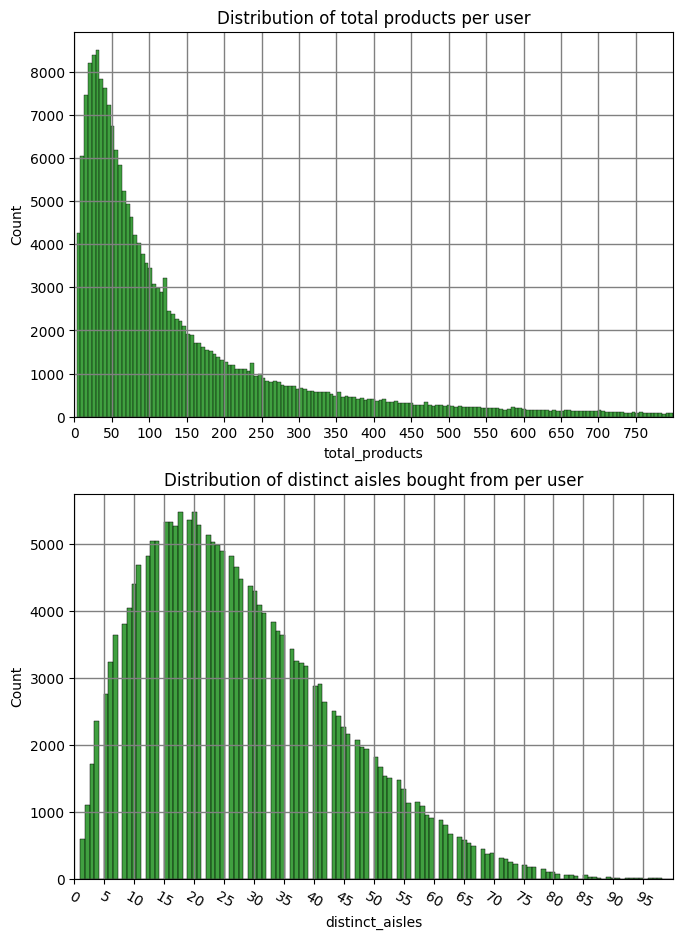

In [18]:
plt.figure(figsize=(17,11))
plt.subplot(2,2,1)
plt.title('Distribution of total products per user')
plt.xticks( np.arange(0, 800, 50), rotation=0 )
plt.xlim((0,800))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['total_products'], color='green')


plt.subplot(2,2,3)
plt.title('Distribution of distinct aisles bought from per user')
plt.xticks( np.arange(0, 100, 5), rotation=-30 )
plt.xlim((0,100))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['distinct_aisles'], color='green')

**FEATURE SCALING**

Feature scaling is often recommended when using distance-based clustering algorithms like K-means. Scaling ensures that all features contribute equally to the distance computations, preventing features with larger scales from dominating the clustering process.

MixMax scaling scales the feature into a specific range. Robust scaling is better for data with outliers.

In [31]:
df_feat2 = df_feat.copy()

<Axes: xlabel='total_products'>

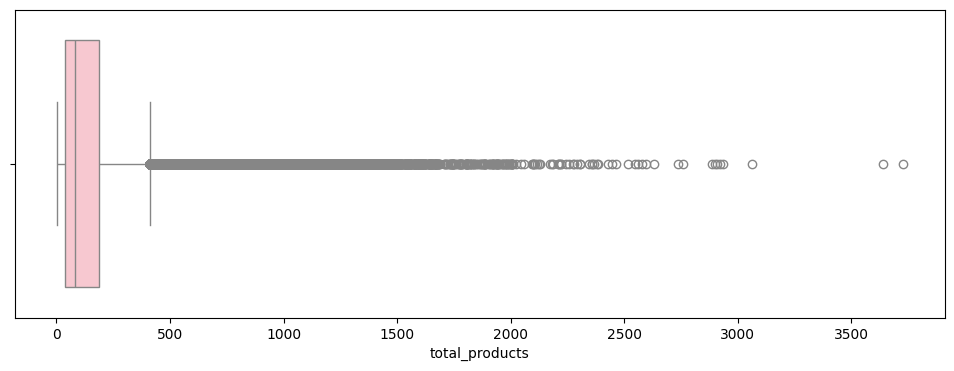

In [32]:
plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

There are some outliers, so we will use Robust scaling

<Axes: xlabel='distinct_aisles'>

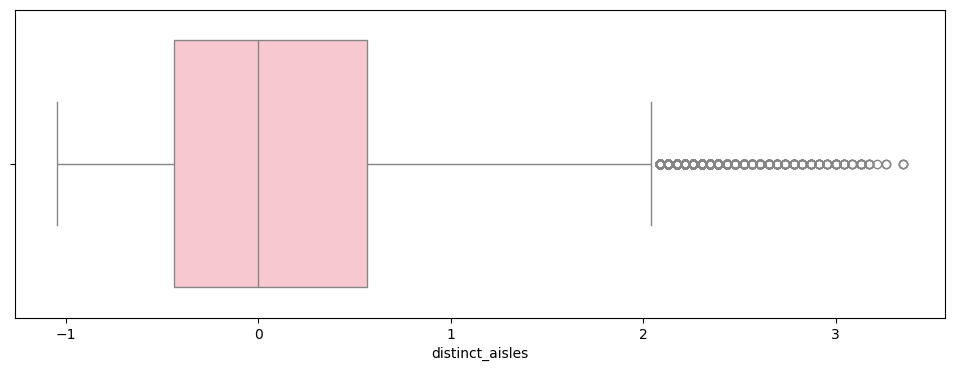

In [33]:
rs = RobustScaler()
df_feat2['distinct_aisles'] = rs.fit_transform( df_feat2[['distinct_aisles']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['distinct_aisles'], orient='h', color='pink')

<Axes: xlabel='total_products'>

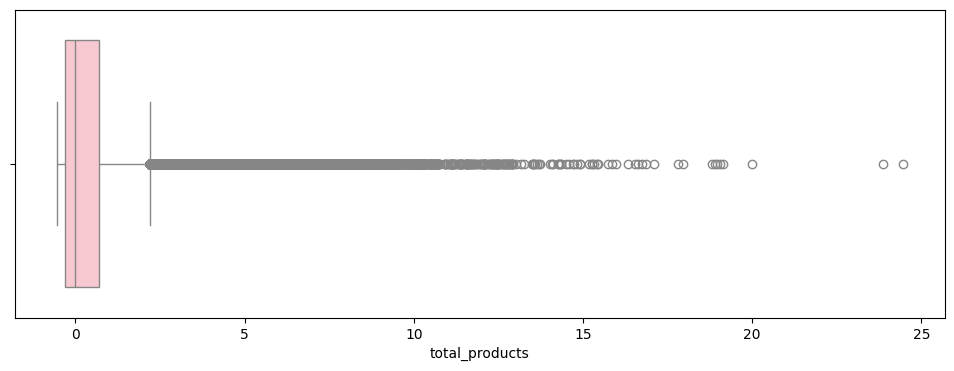

In [34]:
rs = RobustScaler()
df_feat2['total_products'] = rs.fit_transform( df_feat2[['total_products']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

In [35]:
small_constant = 1e-9
df_feat2['total_products'] = np.where(df_feat2['total_products'] <= 0, small_constant, df_feat2['total_products'])
df_feat2['distinct_aisles'] = np.where(df_feat2['distinct_aisles'] <= 0, small_constant, df_feat2['distinct_aisles'])

df_feat2['total_products'] = np.log1p( df_feat2['total_products'] )
df_feat2['distinct_aisles'] = np.log1p( df_feat2['distinct_aisles'] )

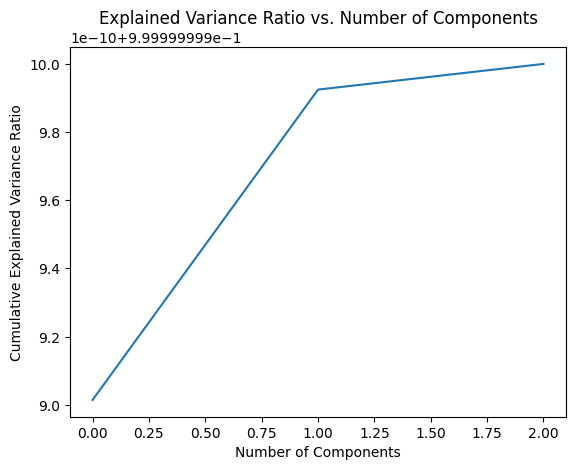

In [36]:
from sklearn.decomposition import PCA
pca2 = PCA()


pca2.fit(df_feat2)


# Plot explained variance ratio
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

In [37]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=1)
pca_df2 = pca2.fit_transform(df_feat2[['total_products', 'distinct_aisles']])
pca_df2 = pd.DataFrame(pca_df2)
display(pca_df2)

,0
0,-0.405222
1,0.229531
2,-0.376610
3,-0.405222
4,-0.405222
...,...
206204,-0.405222
206205,0.704330
206206,0.492468
206207,1.473883


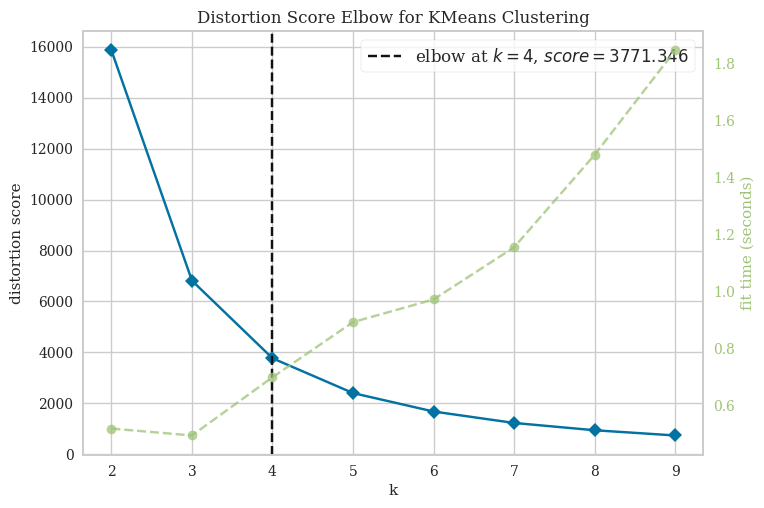

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(n_init=10)
elbow_chart2 = KElbowVisualizer(kmeans, k=(2,10))
elbow_chart2.fit(pca_df2)
elbow_chart2.show()

In [40]:
kmeans2 = KMeans(n_clusters=4, random_state=42)
cluster_labels2 = kmeans2.fit_predict(pca_df2)
df_feat['cluster'] = cluster_labels2

/home/miverson/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [41]:
num_clusters2 = df_feat['cluster'].nunique()
cluster_results2 = []

# Iterate through each cluster
for cluster_num in range(num_clusters2):
    cluster_data = df_feat[df_feat['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results2.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results2:
    cluster_name, cluster_mean = result
    print(f"Cluster {cluster_name}")
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster Cluster 0


,Feature,Mean
0,user_id,102749.691392
1,total_products,327.574030
2,distinct_aisles,46.223545




Cluster Cluster 1


,Feature,Mean
0,user_id,103133.573506
1,total_products,51.881096
2,distinct_aisles,17.956177




Cluster Cluster 2


,Feature,Mean
0,user_id,102644.462114
1,total_products,747.717870
2,distinct_aisles,59.325112




Cluster Cluster 3


,Feature,Mean
0,user_id,103428.853871
1,total_products,164.823347
2,distinct_aisles,35.138768


In [43]:
cluster_user_ids2 = df_feat.groupby('cluster')['user_id'].unique()

# Print user IDs for each cluster
for cluster_label, user_ids in cluster_user_ids2.items():
    print(f"Cluster {cluster_label} User IDs: {user_ids}")

Cluster 0 User IDs: [    14     17     19 ... 206201 206206 206207]
Cluster 1 User IDs: [     1      3      4 ... 206198 206204 206205]
Cluster 2 User IDs: [    27     54     63 ... 206165 206174 206208]
Cluster 3 User IDs: [     2      7     10 ... 206202 206203 206209]


**NEW CLUSTERING BELOW**
.

.

---



**CLUSTERS BASED ON PRODUCTS**



In [47]:
cross_order_product = pd.crosstab(order_products.user_id, order_products.aisle)
cross_order_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [48]:
normalize_df = cross_order_product.div(cross_order_product.sum(axis=1), axis=0)
normalize_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


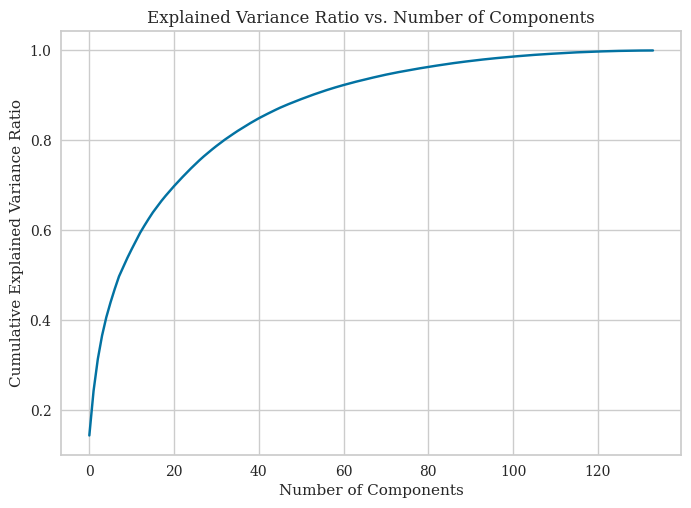

In [76]:
import numpy as np
import matplotlib.pyplot as plt
normalized2 = normalize_df.copy()
# Fit PCA with a range of components
pca = PCA()
pca.fit(normalized2)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=80)
pca_df = pca.fit_transform(normalized2)
pca_df = pd.DataFrame(pca_df)
display(pca_df)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.113443,0.039084,-0.042863,0.018865,-0.088341,-0.104549,-0.116443,0.083694,-0.062523,-0.026177,...,-0.000613,-0.011732,-0.007647,0.000988,0.002190,0.000663,-0.000356,0.001610,-0.000645,-0.000251
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033960,-0.054736,-0.053366,-0.020370,-0.008092,...,-0.004198,-0.008055,-0.002029,-0.000410,0.002120,-0.002453,0.002605,-0.003373,0.001936,-0.000359
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112238,-0.029812,0.007860,0.012277,0.001852,...,-0.003698,-0.002253,0.002568,-0.003966,-0.001834,0.000669,0.000842,-0.002667,-0.001266,0.000801
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019278,-0.025115,-0.038234,0.006492,-0.000623,...,-0.006427,0.023661,-0.016686,-0.032226,-0.019847,-0.018672,0.006629,-0.011475,-0.006721,0.001618
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107649,-0.008034,0.103931,0.051732,-0.025799,...,0.003968,-0.001519,0.003535,-0.004968,0.000662,-0.001093,-0.003941,-0.005930,0.001241,0.000736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,-0.026367,0.027732,-0.067101,-0.033285,0.118231,-0.058467,0.051550,0.017584,-0.026899,-0.023100,...,-0.004668,0.001252,0.002533,0.000208,0.004456,-0.000546,0.000484,-0.005666,-0.001946,-0.003289
206205,-0.089921,-0.045631,-0.048018,0.012692,-0.060298,-0.002377,-0.013544,-0.044109,0.157265,-0.011178,...,0.000969,0.004521,-0.005325,-0.011163,-0.011482,-0.000665,-0.002817,-0.003045,-0.001815,-0.004095
206206,-0.024815,-0.013314,-0.003664,-0.031273,0.032279,0.021374,0.037840,0.032540,-0.020156,-0.009905,...,0.015922,-0.006365,0.008925,-0.004155,0.004908,-0.007973,-0.000242,0.000743,-0.000942,0.000375
206207,-0.009370,-0.003186,-0.045535,-0.012414,0.013405,0.056799,0.008895,0.027282,-0.016115,0.013962,...,0.000244,0.000865,0.000662,-0.002726,0.001387,-0.004746,-0.003608,-0.001571,0.000027,-0.000751


**ELBOW METHOD TO FIND OPTIMAL NUMBER OF CLUSTERS**

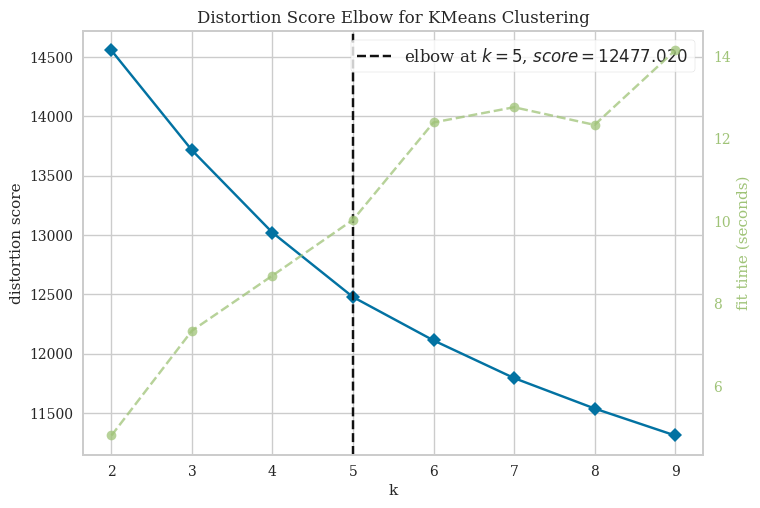

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(n_init=10)
elbow_chart = KElbowVisualizer(kmeans, k=(2,10))
elbow_chart.fit(pca_df)
elbow_chart.show()

**K-MEANS CLUSTERING**

In [53]:
cross_op_product = cross_order_product.copy()

cross_op2 = cross_order_product.drop('fresh fruits', axis=1)
cross_op2 = cross_op2.drop('fresh vegetables', axis=1)
cross_op2 = cross_op2.drop('yogurt', axis=1)
cross_op2 = cross_op2.drop('packaged vegetables fruits', axis=1)
cross_op2 = cross_op2.drop('milk', axis=1)
cross_op2.reset_index(inplace=True)
cross_op2

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,3,0,0,0,0,2,0,0,...,0,3,1,1,0,0,0,0,2,0
2,3,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,2,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206205,206206,0,4,0,0,0,0,4,1,0,...,0,1,0,0,0,0,1,0,1,0
206206,206207,0,0,0,0,1,0,0,0,0,...,0,3,4,0,2,1,0,0,11,0
206207,206208,0,3,0,0,3,0,4,0,0,...,0,5,0,0,7,0,0,0,0,0


**Without produce**

In [78]:
kmeans = KMeans(n_init=10, n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cross_op2['cluster'] = cluster_labels

**With produce**

In [55]:
cross_op_product['cluster'] = cluster_labels

In [79]:
# See cluster 1
cluster1 = cross_op2[cross_op2.cluster == 1]
cluster1_mean = cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
print(cluster1.shape)
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]

(38276, 131)


aisle
user_id                          103068.521058
packaged cheese                       5.156652
soy lactosefree                       3.787334
water seltzer sparkling water         3.626006
bread                                 3.215670
chips pretzels                        3.133373
frozen produce                        2.988426
refrigerated                          2.934345
energy granola bars                   2.526335
eggs                                  2.474318
baby food formula                     2.437925
crackers                              2.318738
lunch meat                            2.198715
fresh dips tapenades                  2.060586
ice cream ice                         2.017295
cereal                                1.801651
nuts seeds dried fruit                1.730980
cream                                 1.619631
spreads                               1.603877
juice nectars                         1.574224
dtype: float64

In [57]:
cluster_user_ids = cross_op2.groupby('cluster')['user_id'].unique()

# Print user IDs for each cluster
for cluster_label, user_ids in cluster_user_ids.items():
    print(f"Cluster {cluster_label} User IDs: {user_ids}")

Cluster 0 User IDs: [     1      4      7 ... 206207 206208 206209]
Cluster 1 User IDs: [     2      3     20 ... 206194 206200 206202]
Cluster 2 User IDs: [    30     76     92 ... 206145 206159 206171]
Cluster 3 User IDs: [     5      6      8 ... 206196 206198 206203]
Cluster 4 User IDs: [    52     81     98 ... 206137 206138 206142]


# Get results for all 5 clusters

In [59]:
num_clusters = cross_op2['cluster'].nunique()
cluster_results = []

# Iterate through each cluster
for cluster_num in range(num_clusters):
    cluster_data = cross_op2[cross_op2['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results:
    cluster_name, cluster_mean = result
    print(cluster_name)
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster 0


,aisle,Mean
0,user_id,103241.244019
1,packaged cheese,4.919869
2,chips pretzels,4.480329
3,water seltzer sparkling water,4.100166
4,refrigerated,3.256345
5,ice cream ice,3.097357
6,bread,3.034675
7,soy lactosefree,2.797880
8,frozen meals,2.747019
9,crackers,2.686631




Cluster 1


,aisle,Mean
0,user_id,103068.521058
1,packaged cheese,5.156652
2,soy lactosefree,3.787334
3,water seltzer sparkling water,3.626006
4,bread,3.215670
5,chips pretzels,3.133373
6,frozen produce,2.988426
7,refrigerated,2.934345
8,energy granola bars,2.526335
9,eggs,2.474318




Cluster 2


,aisle,Mean
0,user_id,103402.412731
1,water seltzer sparkling water,20.916558
2,soft drinks,2.806235
3,energy granola bars,1.526414
4,chips pretzels,1.319582
5,tea,1.319022
6,soy lactosefree,1.070375
7,candy chocolate,1.046108
8,cream,1.042748
9,coffee,0.988240




Cluster 3


,aisle,Mean
0,user_id,102741.964931
1,packaged cheese,5.004060
2,fresh herbs,4.159696
3,soy lactosefree,3.710143
4,frozen produce,3.294276
5,water seltzer sparkling water,3.075707
6,eggs,2.780604
7,bread,2.729205
8,chips pretzels,2.567820
9,canned jarred vegetables,2.477238




Cluster 4


,aisle,Mean
0,user_id,103927.045603
1,packaged produce,18.371504
2,water seltzer sparkling water,1.722852
3,packaged cheese,1.558831
4,chips pretzels,1.145503
5,frozen produce,1.140086
6,nuts seeds dried fruit,1.033006
7,oils vinegars,0.931847
8,bread,0.888385
9,cereal,0.871252


# Clusters including product

In [60]:
num_clusters = cross_op_product['cluster'].nunique()
cluster_results = []

# Iterate through each cluster
for cluster_num in range(num_clusters):
    cluster_data = cross_op_product[cross_op_product['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results:
    cluster_name, cluster_mean = result
    print(cluster_name)
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster 0


,aisle,Mean
0,fresh fruits,9.731400
1,fresh vegetables,7.553750
2,yogurt,7.200584
3,packaged vegetables fruits,5.982612
4,packaged cheese,4.919869
5,chips pretzels,4.480329
6,milk,4.249202
7,water seltzer sparkling water,4.100166
8,refrigerated,3.256345
9,ice cream ice,3.097357




Cluster 1


,aisle,Mean
0,fresh fruits,35.716768
1,fresh vegetables,15.107038
2,packaged vegetables fruits,12.129428
3,yogurt,9.928127
4,milk,5.967473
5,packaged cheese,5.156652
6,soy lactosefree,3.787334
7,water seltzer sparkling water,3.626006
8,bread,3.215670
9,chips pretzels,3.133373




Cluster 2


,aisle,Mean
0,water seltzer sparkling water,20.916558
1,fresh fruits,3.288594
2,soft drinks,2.806235
3,yogurt,2.221766
4,energy granola bars,1.526414
5,chips pretzels,1.319582
6,tea,1.319022
7,milk,1.309128
8,packaged vegetables fruits,1.214486
9,soy lactosefree,1.070375




Cluster 3


,aisle,Mean
0,fresh vegetables,37.053717
1,fresh fruits,21.701987
2,packaged vegetables fruits,12.016223
3,yogurt,6.144892
4,packaged cheese,5.004060
5,fresh herbs,4.159696
6,milk,3.991484
7,soy lactosefree,3.710143
8,frozen produce,3.294276
9,water seltzer sparkling water,3.075707




Cluster 4


,aisle,Mean
0,packaged produce,18.371504
1,fresh fruits,10.874906
2,packaged vegetables fruits,4.227639
3,fresh vegetables,3.107710
4,water seltzer sparkling water,1.722852
5,milk,1.618544
6,packaged cheese,1.558831
7,chips pretzels,1.145503
8,frozen produce,1.140086
9,nuts seeds dried fruit,1.033006


**SUMMARY DATA**

[Reference](https://github.com/gabrielhpr/InstacartClustering/blob/master/InstacartClustering.ipynb)

In [61]:
num_data = order_products.select_dtypes( include=['int64'] )
cat_data = order_products.select_dtypes( exclude=['int64'] )


min_df = pd.DataFrame( num_data.apply(lambda x: min(x), axis=0) ).T
min_df['days_since_prior_order'] = min( num_data[ num_data['days_since_prior_order'] != -1 ]['days_since_prior_order'] )

max_df = pd.DataFrame( num_data.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( num_data.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( num_data.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( num_data.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( num_data.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( num_data.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( num_data.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,order_id,2.0,3421083.0,3421081.0,1.710749e+06,1711048.0,987300.681233,-0.000490,-1.199128
1,product_id,1.0,49688.0,49687.0,2.557634e+04,25256.0,14096.688873,-0.021131,-1.140816
2,add_to_cart_order,1.0,145.0,144.0,8.351076e+00,6.0,7.126671,1.818071,5.643873
3,reordered,0.0,1.0,1.0,5.896975e-01,1.0,0.491889,-0.364706,-1.866989
4,aisle_id,1.0,134.0,133.0,7.121430e+01,83.0,38.203023,-0.167779,-1.324764
5,department_id,1.0,21.0,20.0,9.921906e+00,9.0,6.281155,0.150884,-1.560794
6,user_id,1.0,206209.0,206208.0,1.029372e+05,102611.0,59466.477351,0.006612,-1.200923
7,order_number,1.0,99.0,98.0,1.714205e+01,11.0,17.535040,1.756896,3.256605
8,order_dow,0.0,6.0,6.0,2.738818e+00,3.0,2.090049,0.180193,-1.333989
9,order_hour_of_day,0.0,23.0,23.0,1.342498e+01,13.0,4.246365,-0.044083,-0.011658


**Comparing clusters**

**Without produce**

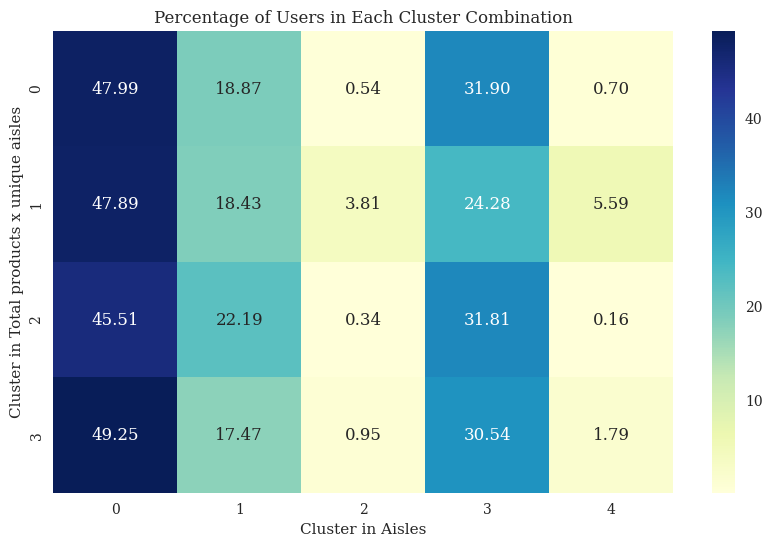

In [80]:
# Without produce

cross_op3 = cross_op2.copy()
cross_op3.rename(columns={'cluster': 'cluster_cross_op'}, inplace=True)

df_feat_final = df_feat.copy()
combined_df = pd.merge(df_feat_final, cross_op3, on='user_id', how='inner')

# Group by cluster labels from both DataFrames
grouped = combined_df.groupby(['cluster', 'cluster_cross_op']).size().reset_index(name='count')

# Calculate the total count of users in each cluster from df_feat2
total_users_df_feat2 = df_feat_final.groupby('cluster').size()

# Calculate the percentage of users in each combination relative to the total number of users in the corresponding cluster from df_feat2
grouped['percentage'] = grouped.apply(lambda row: (row['count'] / total_users_df_feat2[row['cluster']]) * 100, axis=1)


heatmap_data = grouped.pivot(index='cluster', columns='cluster_cross_op', values='percentage')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Percentage of Users in Each Cluster Combination')
plt.xlabel('Cluster in Aisles')
plt.ylabel('Cluster in Total products x unique aisles')
plt.show()

**With Produce**

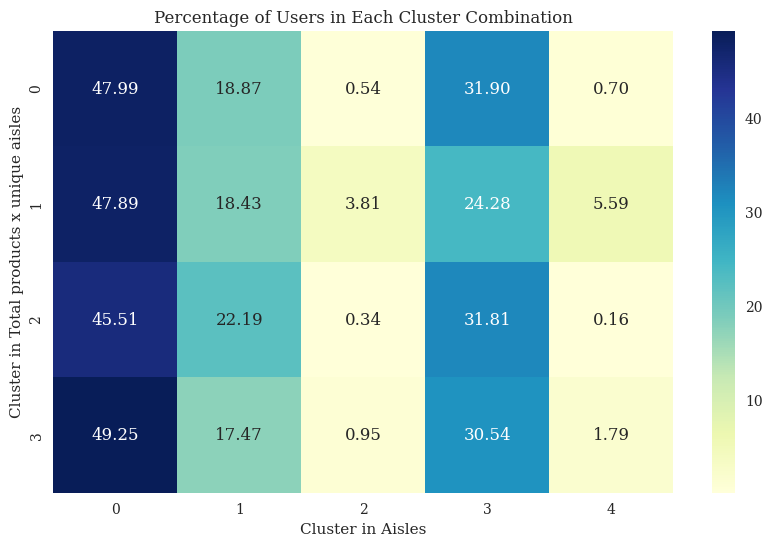

In [72]:
# With produce

cross_op_product2 = cross_op_product.copy()
cross_op_product2.rename(columns={'cluster': 'cluster_cross_op'}, inplace=True)

df_feat_final2 = df_feat.copy()
combined_df = pd.merge(df_feat_final2, cross_op_product2, on='user_id', how='inner')

# Group by cluster labels from both DataFrames
grouped = combined_df.groupby(['cluster', 'cluster_cross_op']).size().reset_index(name='count')

# Calculate the total count of users in each cluster from df_feat2
total_users_df_feat2 = df_feat_final2.groupby('cluster').size()

# Calculate the percentage of users in each combination relative to the total number of users in the corresponding cluster from df_feat2
grouped['percentage'] = grouped.apply(lambda row: (row['count'] / total_users_df_feat2[row['cluster']]) * 100, axis=1)


heatmap_data = grouped.pivot(index='cluster', columns='cluster_cross_op', values='percentage')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Percentage of Users in Each Cluster Combination')
plt.xlabel('Cluster in Aisles')
plt.ylabel('Cluster in Total products x unique aisles')
plt.show()